In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
FILE   = "HMEQ_Loss.csv"

df = pd.read_csv( FILE, encoding="ISO-8859-1" )

In [4]:
TARGET_FLAG = 'TARGET_BAD_FLAG'
TARGET_LOSS = 'TARGET_LOSS_AMT'

In [5]:
df1 = df.copy()
df1 = df1.drop( [TARGET_FLAG], axis=1 )
df1 = df1.drop( [TARGET_LOSS], axis=1 )

In [6]:
varNames = df1.columns

print( df1.head() )
print( "\n\n")
print( df1.describe() )

   LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ       CLAGE  \
0  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   94.366667   
1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0  121.833333   
2  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0  149.466667   
3  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN         NaN   
4  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   93.333333   

   NINQ  CLNO  DEBTINC  
0   1.0   9.0      NaN  
1   0.0  14.0      NaN  
2   1.0  10.0      NaN  
3   NaN   NaN      NaN  
4   0.0  14.0      NaN  



               LOAN        MORTDUE          VALUE          YOJ        DEROG  \
count   5960.000000    5442.000000    5848.000000  5445.000000  5252.000000   
mean   18607.969799   73760.817200  101776.048741     8.922268     0.254570   
std    11207.480417   44457.609458   57385.775334     7.573982     0.846047   
min     1100.000000    2063.000000    8000.000000 

In [7]:
dt = df1.dtypes

#create a new list of categorical and numerical variables
objList = []
numList = []
for i in dt.index :
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )


print(" OBJECTS ")
print(" ------- ")
for i in objList :
    print( i )
print(" ------- \n\n")


print(" NUMBER ")
print(" ------- ")
for i in numList :
    print( i )
print(" ------- ")

 OBJECTS 
 ------- 
REASON
JOB
 ------- 


 NUMBER 
 ------- 
LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC
 ------- 


In [8]:
#drop object variables 
for i in objList:
    df1 = df1.drop( [i], axis=1 )

varNames = df1.columns
print(varNames)

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')


In [9]:
impList = []
mList = []

#fill missing numeric values with the median
for i in numList :
    if df1[i].isna().sum() == 0 : continue 
    FLAG = "M_" + i 
    IMP = "IMP_" + i
    df1[ FLAG ] = df1[i].isna() + 0 
    df1[ IMP ] = df1[ i ]
    impList.append(IMP) #use list for numerical columns for removing outliers
    mList.append(FLAG) #use list for appending flag missing value variables later if needed
    df1.loc[ df1[IMP].isna(), IMP ] = df1[i].median()
    df1 = df1.drop( i, axis=1 )

print(df1.head().T)

                        0             1             2             3  \
LOAN          1100.000000   1300.000000   1500.000000   1500.000000   
M_MORTDUE        0.000000      0.000000      0.000000      1.000000   
IMP_MORTDUE  25860.000000  70053.000000  13500.000000  65019.000000   
M_VALUE          0.000000      0.000000      0.000000      1.000000   
IMP_VALUE    39025.000000  68400.000000  16700.000000  89235.500000   
M_YOJ            0.000000      0.000000      0.000000      1.000000   
IMP_YOJ         10.500000      7.000000      4.000000      7.000000   
M_DEROG          0.000000      0.000000      0.000000      1.000000   
IMP_DEROG        0.000000      0.000000      0.000000      0.000000   
M_DELINQ         0.000000      0.000000      0.000000      1.000000   
IMP_DELINQ       0.000000      2.000000      0.000000      0.000000   
M_CLAGE          0.000000      0.000000      0.000000      1.000000   
IMP_CLAGE       94.366667    121.833333    149.466667    173.466667   
M_NINQ

In [10]:
truncList = []

for i in impList :
    theMean = df1[i].mean()
    theSD = df1[i].std()
    theMax = df1[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df1[ FLAG ] = ( df1[i] > theCutoff )+ 0
    df1[ TRUNC ] = df1[ i ]
    truncList.append(TRUNC) #use list for numerical columns for data transformation
    df1.loc[ df1[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df1 = df1.drop( i, axis=1 )

In [11]:
X = df1.copy() 
X = X[truncList]
varNames = X.columns 

print( X.head().T )
print( "\n\n")
print( X.describe() )

                              0             1             2             3  \
TRUNC_IMP_MORTDUE  25860.000000  70053.000000  13500.000000  65019.000000   
TRUNC_IMP_VALUE    39025.000000  68400.000000  16700.000000  89235.500000   
TRUNC_IMP_YOJ         10.500000      7.000000      4.000000      7.000000   
TRUNC_IMP_DEROG        0.000000      0.000000      0.000000      0.000000   
TRUNC_IMP_DELINQ       0.000000      2.000000      0.000000      0.000000   
TRUNC_IMP_CLAGE       94.366667    121.833333    149.466667    173.466667   
TRUNC_IMP_NINQ         1.000000      0.000000      1.000000      1.000000   
TRUNC_IMP_CLNO         9.000000     14.000000     10.000000     20.000000   
TRUNC_IMP_DEBTINC     34.818262     34.818262     34.818262     34.818262   

                               4  
TRUNC_IMP_MORTDUE   97800.000000  
TRUNC_IMP_VALUE    112000.000000  
TRUNC_IMP_YOJ           3.000000  
TRUNC_IMP_DEROG         0.000000  
TRUNC_IMP_DELINQ        0.000000  
TRUNC_IMP_CLAGE    

In [12]:
#transform the data - most times people standardize for clustering

#theScaler = MinMaxScaler()
theScaler = StandardScaler()
theScaler.fit( X )

X_TRN = theScaler.transform( X )
X_TRN = pd.DataFrame( X_TRN )
print( X_TRN.head() )

          0         1         2         3         4         5         6  \
0 -1.187821 -1.218785  0.243923 -0.329584 -0.418963 -1.067294 -0.081701   
1 -0.055078 -0.636046 -0.241631 -0.329584  1.837718 -0.718939 -0.791521   
2 -1.504630 -1.661666 -0.657820 -0.329584 -0.418963 -0.368469 -0.081701   
3 -0.184108 -0.222713 -0.241631 -0.329584 -0.418963 -0.064081 -0.081701   
4  0.656126  0.228887 -0.796550 -0.329584 -0.418963 -1.080400 -0.791521   

          7         8  
0 -1.247113  0.141543  
1 -0.736029  0.141543  
2 -1.144896  0.141543  
3 -0.122729  0.141543  
4 -0.736029  0.141543  


In [13]:
varNames_trn = []
for i in varNames :
    newName = "trn_" + i
    varNames_trn.append( newName )

X_TRN.columns = varNames_trn
print( X_TRN.head() )
print( "\n\n")
print( X_TRN.describe() )

   trn_TRUNC_IMP_MORTDUE  trn_TRUNC_IMP_VALUE  trn_TRUNC_IMP_YOJ  \
0              -1.187821            -1.218785           0.243923   
1              -0.055078            -0.636046          -0.241631   
2              -1.504630            -1.661666          -0.657820   
3              -0.184108            -0.222713          -0.241631   
4               0.656126             0.228887          -0.796550   

   trn_TRUNC_IMP_DEROG  trn_TRUNC_IMP_DELINQ  trn_TRUNC_IMP_CLAGE  \
0            -0.329584             -0.418963            -1.067294   
1            -0.329584              1.837718            -0.718939   
2            -0.329584             -0.418963            -0.368469   
3            -0.329584             -0.418963            -0.064081   
4            -0.329584             -0.418963            -1.080400   

   trn_TRUNC_IMP_NINQ  trn_TRUNC_IMP_CLNO  trn_TRUNC_IMP_DEBTINC  
0           -0.081701           -1.247113               0.141543  
1           -0.791521           -0.736029 

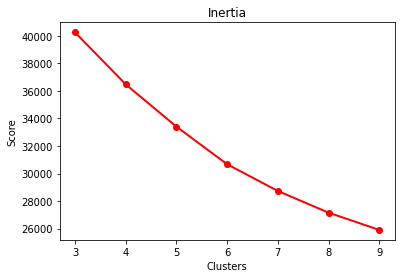

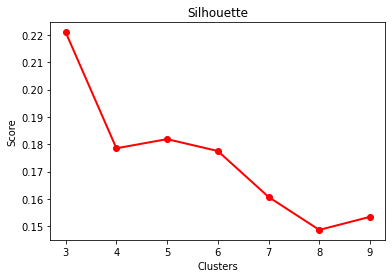

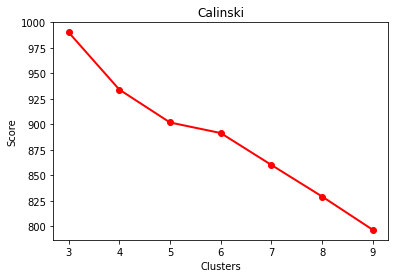

In [14]:
K_LIST = []
I_LIST = []
S_LIST = []
C_LIST = []


for K in range(3,10) :  #look for 3-9 clusters 
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( X_TRN )
    Y = km.predict( X_TRN ) #put trained data into clusters
    K_LIST.append( K )
    I_LIST.append( km.inertia_ ) #get inertia score
    S_LIST.append( silhouette_score(X_TRN,km.labels_) ) #silhouette score
    C_LIST.append( calinski_harabasz_score(X_TRN,km.labels_) )  #calinski harabasz score



def drawElbow( K, SCORE, LABEL ) :
    plt.plot( K , SCORE, 'ro-', linewidth=2)
    plt.title(LABEL)
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.show()

drawElbow( K_LIST, I_LIST, "Inertia" )
drawElbow( K_LIST, S_LIST, "Silhouette" )
drawElbow( K_LIST, C_LIST, "Calinski" )

In [15]:
def clusterData( DATA, TRN_DATA, K, TARGET ) :
    print("\n\n\n")
    print("K = ",K)
    print("=======")
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( TRN_DATA )
    Y = km.predict( TRN_DATA )
    DATA["CLUSTER"] = Y
    print( DATA.head() )

    G = DATA.groupby("CLUSTER")
    print( G.mean() )
    print("\n\n\n")
    print( G[ TARGET ].value_counts() )

In [16]:
clusterData( df, X_TRN, 4, TARGET_FLAG )





K =  4
   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  MORTDUE     VALUE   REASON     JOB  \
0                1            641.0  1100  25860.0   39025.0  HomeImp   Other   
1                1           1109.0  1300  70053.0   68400.0  HomeImp   Other   
2                1            767.0  1500  13500.0   16700.0  HomeImp   Other   
3                1           1425.0  1500      NaN       NaN      NaN     NaN   
4                0              NaN  1700  97800.0  112000.0  HomeImp  Office   

    YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  DEBTINC  CLUSTER  
0  10.5    0.0     0.0   94.366667   1.0   9.0      NaN        1  
1   7.0    0.0     2.0  121.833333   0.0  14.0      NaN        1  
2   4.0    0.0     0.0  149.466667   1.0  10.0      NaN        1  
3   NaN    NaN     NaN         NaN   NaN   NaN      NaN        1  
4   3.0    0.0     0.0   93.333333   0.0  14.0      NaN        1  
         TARGET_BAD_FLAG  TARGET_LOSS_AMT          LOAN        MORTDUE  \
CLUSTER                   

### Bingo Bonus
Use PCA for clustering

In [17]:
pca = PCA()
pca.fit( X_TRN )
X_TRN = pca.transform( X_TRN )
X_TRN = pd.DataFrame( X_TRN )

In [18]:
varNames_trn = []
for i in range(X_TRN.shape[1]) :
    index = str(i+1)
    newName = "PC_" + index
    varNames_trn.append( newName )

In [19]:
X_TRN.columns = varNames_trn
X_TRN = X_TRN.iloc[:,0:5] #use first 5 as we found in the pca assignment
print( X_TRN.head() )

       PC_1      PC_2      PC_3      PC_4      PC_5
0 -2.213738 -0.064566 -0.523838 -0.573712  0.032002
1 -0.796038  0.403654  0.303282  0.735630 -1.345805
2 -2.464173  0.034273 -0.504138 -0.572960 -0.541261
3 -0.306641 -0.228400 -0.397817 -0.321428 -0.171620
4 -0.092079 -0.314853 -1.601887  0.539274 -0.531030


In [20]:
K_LIST = []
I_LIST = []
S_LIST = []
C_LIST = []

for K in range(3,12) :
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( X_TRN )
    Y = km.predict( X_TRN )
    K_LIST.append( K )
    I_LIST.append( km.inertia_ )
    S_LIST.append( silhouette_score(X_TRN,km.labels_) )
    C_LIST.append( calinski_harabasz_score(X_TRN,km.labels_) )

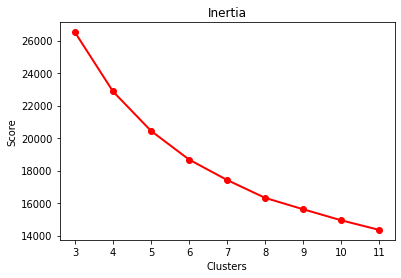

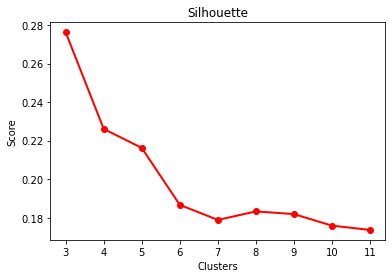

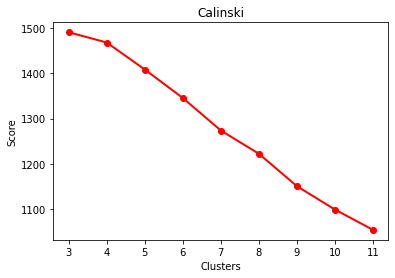

In [21]:
def drawElbow( K, SCORE, LABEL ) :
    plt.plot( K , SCORE, 'ro-', linewidth=2)
    plt.title(LABEL)
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.show()


drawElbow( K_LIST, I_LIST, "Inertia" )
drawElbow( K_LIST, S_LIST, "Silhouette" )
drawElbow( K_LIST, C_LIST, "Calinski" )

In [22]:
def clusterData( DATA, TRN_DATA, K, TARGET ) :
    print("\n\n\n")
    print("K = ",K)
    print("=======")
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( TRN_DATA )
    Y = km.predict( TRN_DATA )
    DATA["CLUSTER"] = Y
    print( DATA.head() )

    G = DATA.groupby("CLUSTER")
    print( G.mean() )
    print("\n\n\n")
    print( G[ TARGET ].value_counts() )

In [24]:
clusterData( df, X_TRN, 4, TARGET_FLAG )





K =  4
   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  MORTDUE     VALUE   REASON     JOB  \
0                1            641.0  1100  25860.0   39025.0  HomeImp   Other   
1                1           1109.0  1300  70053.0   68400.0  HomeImp   Other   
2                1            767.0  1500  13500.0   16700.0  HomeImp   Other   
3                1           1425.0  1500      NaN       NaN      NaN     NaN   
4                0              NaN  1700  97800.0  112000.0  HomeImp  Office   

    YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  DEBTINC  CLUSTER  
0  10.5    0.0     0.0   94.366667   1.0   9.0      NaN        0  
1   7.0    0.0     2.0  121.833333   0.0  14.0      NaN        0  
2   4.0    0.0     0.0  149.466667   1.0  10.0      NaN        0  
3   NaN    NaN     NaN         NaN   NaN   NaN      NaN        0  
4   3.0    0.0     0.0   93.333333   0.0  14.0      NaN        0  
         TARGET_BAD_FLAG  TARGET_LOSS_AMT          LOAN        MORTDUE  \
CLUSTER                   